# Minimum Viable Product (MVP) Overview - Final
This notebook works the entire MVP data science pipeline against the KDD CUP 99 dataset, a network intrusion dataset with nearly 4 million rows, 41 features, and a label column for the nature of each observation.

**Because this dataset is labeled**, I chose to pursue **binary classification** as my minimum-viable product strategy. My goal was to predict whether an observation was normal or anomalous. Through data wrangling, exploration, hypothesis testing, and preparation for modeling, I selected useful features for predicting class. I created a Random Forest classifier and fit it on the training split, then evaluated a baseline guess and the model's predictions on the training split and validation split. The MVP model outperformed the baseline significantly.

# Bottom Line Up Front: My Work
1. Selected the KDD CUP 99 dataset for network intrusion analysis
2. Used Spark to understand dataset features and distributions
3. Created analytic strategy, objectives, and plan based on dataset features
    * Created plan for MVP, Post-MVP, and Model Deployment
4. Used Spark to prepare dataset for analysis
5. Used Spark to split data into model training, validation, and testing splits
6. Exported splits to Pandas dataframes for hypothesis testing
7. Created hypotheses based on instrusion categories
8. Visualized hypotheses in Seaborn
9. Conducted statistical testing to determine feature significance
10. Selected features that proved significant from hypothesis testing
11. Scaled and resampled selected features for modeling
12. Calculated baseline F1 score among other metrics
13. Created a Random Forest Classifier, fit on scaled and resampled training data
14. Evaluated fit model on training data and validation split
15. Calculated model F1 score among other metrics
16. Reported model findings

# Imports

In [1]:
# imports
import pandas as pd
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTETomek

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import wrangle
import model

# Wrangling MVP
**Bottom line up front:**
1. Acquire network intrusion dataset
2. Fix column dtypes
3. Reduce DOS attack class rows by 95%
4. Group all attack classes into 'anomalous' class
5. Split data 50%-30%-20% for df, validate, and test splits
6. Return original df and the exploration split (train split)

In [2]:
# perform above steps for wrangling
df, train = wrangle.prep_explore()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/24 22:10:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Exploration MVP
**Bottom line up front:**
- Used attack categories to create the following initial hypotheses (one per category):
    * Hypothesis 1: Anomalies have higher same-server request counts than normal traffic
    * Hypothesis 2: Anomalies have higher failed login counts than normal traffic
    * Hypothesis 3: Anomalies have higher superuser attempts than normal traffic
    * Hypothesis 4: Anomalies have higher different-host connection rate than normal traffic
- Selected the features necessary to conduct the statistical tests, exported them to Pandas
- Conducted each statistical test and documented results
- Chose the two significant features for modeling

## Hypothesis 1: Anomalies have higher same-server request counts than normal traffic
- $H_0$: Anomalies do not have higher average same-server request count than normal traffic.
- $H_a$: Anomalies have higher average same-server request count than normal traffic.
- Confidence Interval: 95%

22/01/24 22:11:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


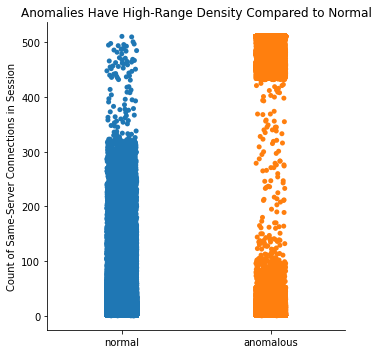

In [3]:
# export required columns to pandas
srv_count_target = train.select('srv_count', 'target').toPandas()

# visualize means
sns.catplot(data=srv_count_target.sort_values(by='target', ascending=False), 
            x='target', 
            y='srv_count', 
            kind='strip')
plt.title('Anomalies Have High-Range Density Compared to Normal')
plt.ylabel('Count of Same-Server Connections in Session')
plt.xlabel('')
plt.show()

In [4]:
# set alpha
alpha = .05

# perform statistical test
t, p = stats.mannwhitneyu(
    srv_count_target[srv_count_target.target != 'normal'].srv_count,
    srv_count_target[srv_count_target.target == 'normal'].srv_count,
    alternative='greater'
)

# print results
if t > 0 and p < alpha:
    print('We reject the null hypothesis. We are 95% confident that anomalies have higher srv_count than normal traffic.')
else:
    print('We accept the null hypothesis. Results do not breach the 95% confidence interval.')

We reject the null hypothesis. We are 95% confident that anomalies have higher srv_count than normal traffic.


## Hypothesis 2: Anomalies have higher failed login counts than normal traffic
- $H_0$: Anomalies do not have higher average failed login count than normal traffic.
- $H_a$: Anomalies have higher average failed login count than normal traffic.
- Confidence Interval: 95%

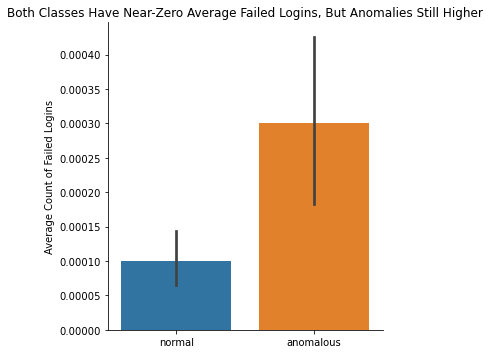

In [5]:
# export required columns to pandas
failed_logins_target = train.select('num_failed_logins', 'target').toPandas()

# visualize means
sns.catplot(data=failed_logins_target.sort_values(by='target', ascending=False), 
            x='target', 
            y='num_failed_logins', 
            kind='bar')
plt.title('Both Classes Have Near-Zero Average Failed Logins, But Anomalies Still Higher')
plt.ylabel('Average Count of Failed Logins')
plt.xlabel('')
plt.show()

In [6]:
# set alpha
alpha = .05

# perform statistical test
t, p = stats.mannwhitneyu(
    failed_logins_target[failed_logins_target.target != 'normal'].num_failed_logins,
    failed_logins_target[failed_logins_target.target == 'normal'].num_failed_logins,
    alternative='greater'
)

# print results
if t > 0 and p < alpha:
    print('We reject the null hypothesis. We are 95% confident that anomalies have higher count of failed logins than normal traffic.')
else:
    print('We accept the null hypothesis. Results do not breach the 95% confidence interval.')

We reject the null hypothesis. We are 95% confident that anomalies have higher count of failed logins than normal traffic.


## Hypothesis 3: Anomalies have higher superuser attempts than normal traffic
- $H_0$: Anomalies do not have higher average superuser attempts than normal traffic.
- $H_a$: Anomalies have higher average superuser attempts than normal traffic.
- Confidence Interval: 95%

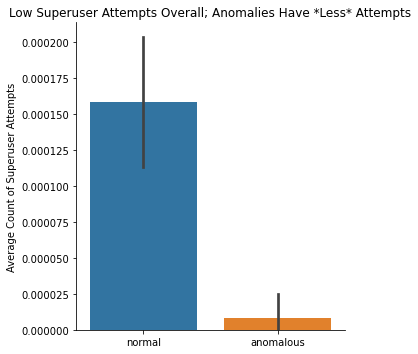

In [7]:
# export required columns to pandas
su_attempts_target = train.select('su_attempted', 'target').toPandas()

# visualize means
sns.catplot(data=su_attempts_target.sort_values(by='target', ascending=False), 
            x='target', 
            y='su_attempted', 
            kind='bar')
plt.title('Low Superuser Attempts Overall; Anomalies Have *Less* Attempts')
plt.ylabel('Average Count of Superuser Attempts')
plt.xlabel('')
plt.show()

In [8]:
# set alpha
alpha = .05

# perform statistical test
t, p = stats.mannwhitneyu(
    su_attempts_target[su_attempts_target.target != 'normal'].su_attempted,
    su_attempts_target[su_attempts_target.target == 'normal'].su_attempted,
    alternative='greater'
)

# print results
if t > 0 and p < alpha:
    print('We reject the null hypothesis. We are 95% confident that anomalies have higher superuser attempts than normal traffic.')
else:
    print('We accept the null hypothesis. Results do not breach the 95% confidence interval.')

We accept the null hypothesis. Results do not breach the 95% confidence interval.


## Hypothesis 4: Anomalies have higher different-host connection rate than normal traffic
- $H_0$: Anomalies do not have higher average different-host connection rate than normal traffic.
- $H_a$: Anomalies have higher average different-host connection rate than normal traffic.
- Confidence Interval: 95%

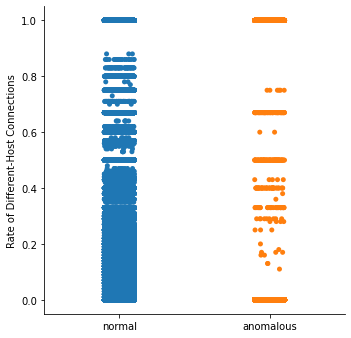

In [9]:
# export required columns to pandas
diff_hosts_target = train.select('srv_diff_host_rate', 'target').toPandas()

# visualize means
sns.catplot(data=diff_hosts_target.sort_values(by='target', ascending=False), 
            x='target', 
            y='srv_diff_host_rate', 
            kind='strip')
plt.title('')
plt.ylabel('Rate of Different-Host Connections')
plt.xlabel('')
plt.show()

### Visual Results for Different Host Rate Hypothesis
1. Due to the existence of 100%-different, it's clear that this is *not* majority_host_count / total_connection_count
2. **Because of this, we can't do a statistical test to answer hypothesis #4.**

## Features to Use in Modeling
1. Hypothesis 1 is significant; use feature: srv_count
2. Hypothesis 2 is significant; use feature: num_failed_logins
3. Hypothesis 3 is not significant; do not use feature: su_attempted
4. Hypothesis 4 is not tested; do not use feature: srv_diff_host_rate
5. **MVP features: srv_count, num_failed_logins**

# Modeling MVP
**Bottom line up front:**
1. Used the significant features from MVP exploration
    1. srv_count
    2. num_failed_logins
2. Scaled features
3. Resampled classes if necessary using SMOTE+Tomek
4. Calculated baseline (always-guessing anomaly)
5. Built a classification model and fit it on train's two features and target
6. Evaluated model on train and validate in terms of F1 Score

## Scaling, Resampling Data
NOTE: Due to the nature of resampling 600,000 observations, this cell will take several minutes to execute.

In [10]:
# scale features using MinMaxScaler, resample classes using SMOTETomek
X_train, y_train, X_validate, y_validate, _, _ = model.prep_model_MVP()

## Calculate, Evaluate Baseline (Always-Guessing Anomalous)

In [11]:
# generate classification reports for actuals and prediction=1
bl_report_train, bl_report_validate = model.bl_evaluation(y_train, y_validate)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/

## Build & Fit Random Forest Classifier, Evaluate

In [12]:
# create rf, fit on scaled features and resampled classes in train, gen classification report
rf_report_train, rf_report_validate = model.rf_evaluation(X_train, y_train, X_validate, y_validate)

## Modeling Results - Classification Confusion Matrices

In [13]:
# baseline metrics for in-sample split (training split)
bl_report_train

,precision,recall,f1-score,support
1,0.50,1.0,0.666667,486792.0
0,0.00,0.0,0.000000,486792.0
accuracy,0.50,0.5,0.500000,0.5
macro avg,0.25,0.5,0.333333,973584.0
weighted avg,0.25,0.5,0.333333,973584.0


In [14]:
# random forest metrics for in-sample split (training split)
rf_report_train

,precision,recall,f1-score,support
1,0.981474,0.596296,0.741868,486792.00000
0,0.710076,0.988745,0.826554,486792.00000
accuracy,0.792520,0.792520,0.792520,0.79252
macro avg,0.845775,0.792520,0.784211,973584.00000
weighted avg,0.845775,0.792520,0.784211,973584.00000


In [15]:
# baseline metrics for out-of-sample split (validation split)
bl_report_validate

,precision,recall,f1-score,support
1,0.196510,1.00000,0.328472,71297.00000
0,0.000000,0.00000,0.000000,291519.00000
accuracy,0.196510,0.19651,0.196510,0.19651
macro avg,0.098255,0.50000,0.164236,362816.00000
weighted avg,0.038616,0.19651,0.064548,362816.00000


In [16]:
# random forest metrics for out-of-sample split (validation split)
rf_report_validate

,precision,recall,f1-score,support
1,0.927900,0.595677,0.725567,71297.000000
0,0.909076,0.988680,0.947209,291519.000000
accuracy,0.911451,0.911451,0.911451,0.911451
macro avg,0.918488,0.792179,0.836388,362816.000000
weighted avg,0.912775,0.911451,0.903654,362816.000000


# Conclusion
With just two features, our Random Forest model (with no hyperparameter tuning) vastly outperformed our baseline. Here are the results:

## 1. Baseline F1 Scores: 67% on in-sample, 33% on out-of-sample
## 2. Random Forest F1 Scores: 74% on in-sample, 73% on out-of-sample